In [2]:
#conda install tensorflow-estimator=2.1.0
#!pip install tensorboard

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings

import argparse
import logging
import pandas as pd
import random
import os
import numpy as np
from loggers import logger

from process import input_data, preprocess

def set_logger(log_name):
    log_obj = logger.AutoMLLog(log_name)
    log_obj.set_handler('automl_process')
    log_obj.set_formats()
    auto_logger = log_obj.addOn()
    
    auto_logger.info('logger 세팅')

In [2]:
import os
import warnings

warnings.filterwarnings("ignore")  # avoid printing out absolute paths

import copy
from pathlib import Path
import warnings

import numpy as np
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

import tensorflow as tf
import tensorboard as tb
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

In [3]:
log_name = 'practice_tft'
set_logger(log_name)
data, var_list, num_var, obj_var = input_data.Data_load('storage/stallion.csv', log_name).read_data()
df = preprocess.Preprocessing(log_name, data, var_list, num_var, obj_var, target_var='volume', date_var= 'date', store_list=['sku','agency'], unit='month').df

logger 세팅
csv 데이터 불러오기
storage/stallion.csv
데이터 구성: 21000 행, 26열
Memory usage of dataframe is 4.17MB
Memory usage after optimization is: 0.91MB
Decreased by 78.2%
결측치 처리
결측치 처리 이후 데이터 구성: 21000 행, 26열
전처리를 위한 target, date, store 분리
정규화 진행
라벨 인코딩 진행
전처리 완료


   avg_max_temp  price_regular  price_actual  discount  discount_in_percent  \
0     -0.696963      -0.413455     -0.337471 -0.328691            -0.213089   
1     -0.531769       0.586046      0.584706  0.218970             0.252862   
2     -1.609464      -0.264188     -0.119687 -0.430163            -0.498605   
3     -0.818892      -0.403211     -0.313651 -0.353452            -0.274591   
4     -1.141414      -0.182238     -0.100971 -0.253193            -0.165842   

   industry_volume  soda_volume  avg_population_2017  \
0        -0.815995    -1.697382            -1.072907   
1        -0.815995    -1.697382            -1.089462   
2        -0.815995    -1.697382             0.188255   
3        -0.815995    -1.697382            

In [4]:
target_var='volume'
date_var= 'date'
store_list=['sku','agency']
unit='month'
predict_n = 7

In [5]:
df.columns

Index(['avg_max_temp', 'price_regular', 'price_actual', 'discount',
       'discount_in_percent', 'industry_volume', 'soda_volume',
       'avg_population_2017', 'avg_yearly_household_income_2017', 'easter_day',
       'good_friday', 'new_year', 'christmas', 'labor_day', 'independence_day',
       'revolution_day_memorial', 'regional_games', 'fifa_u_17_world_cup',
       'football_gold_cup', 'beer_capital', 'music_fest', 'timeseries',
       'volume', 'date', 'sku', 'agency', 'time_idx', 'month'],
      dtype='object')

In [6]:
# add additional features
#data["month"] = data.date.dt.month.astype(str).astype("category")  # categories have be strings
df[f"log_{target_var}"] = np.log(df[target_var] + 1e-4)
for store_var in store_list:
    df[f"avg_{target_var}_by_{store_var}"] = df.groupby(["time_idx", store_var], observed=True)[target_var].transform("mean")

In [7]:
df.head()

,avg_max_temp,price_regular,price_actual,discount,discount_in_percent,industry_volume,soda_volume,avg_population_2017,avg_yearly_household_income_2017,easter_day,...,timeseries,volume,date,sku,agency,time_idx,month,log_volume,avg_volume_by_sku,avg_volume_by_agency
0,-0.696963,-0.413455,-0.337471,-0.328691,-0.213089,-0.815995,-1.697382,-1.072907,-0.376197,-0.301511,...,-1.727109,52.28125,2013-01-01,SKU_01,Agency_22,0,1,3.957031,2614.0,103.8125
1,0.176207,-0.413455,-0.337471,-0.328205,-0.212274,-1.780953,-1.243094,-1.072907,-0.376197,-0.301511,...,-1.727109,62.53125,2013-02-01,SKU_01,Agency_22,1,2,4.136719,2918.0,121.0000
2,0.203739,-0.360773,-0.281323,-0.318738,-0.217162,-0.550900,0.523917,-1.072907,-0.376197,3.316625,...,-1.727109,74.18750,2013-03-01,SKU_01,Agency_22,2,3,4.304688,3216.0,153.8750
3,0.962846,-0.316871,-0.233683,-0.305872,-0.210645,-0.183385,-0.167437,-1.072907,-0.376197,-0.301511,...,-1.727109,89.43750,2013-04-01,SKU_01,Agency_22,3,4,4.492188,3516.0,163.2500
4,0.892048,-0.299310,-0.214967,-0.303444,-0.213903,0.124586,0.168964,-1.072907,-0.376197,-0.301511,...,-1.727109,79.18750,2013-05-01,SKU_01,Agency_22,4,5,4.371094,3688.0,152.6250


In [8]:
max_prediction_length = predict_n
max_encoder_length = predict_n * 4
training_cutoff = df['time_idx'].max() - max_prediction_length

In [9]:
df["time_idx"]

0         0
1         1
2         2
3         3
4         4
         ..
20995    55
20996    56
20997    57
20998    58
20999    59
Name: time_idx, Length: 21000, dtype: int64

In [10]:
training = TimeSeriesDataSet(
    df[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target=target_var,
    group_ids=store_list,
    min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=store_list,
    static_reals=[],
    time_varying_known_categoricals=[unit],
    variable_groups={},  # group of categorical variables can be treated as one variable
    time_varying_known_reals=["time_idx"],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=
    [target_var, f"log_{target_var}"]+ [f"avg_{target_var}_by_{store_var}" for store_var in store_list],
    target_normalizer=GroupNormalizer(
        groups=store_list, transformation="softplus"
    ),  # use softplus and normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(training, df, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 128  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

In [11]:
len(next(iter(train_dataloader))[0]['groups'])

128

In [12]:
# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    gpus=0,
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=16,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=1,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Global seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Number of parameters in network: 22.7k


Global seed set to 42


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restoring states from the checkpoint path at C:\Users\LDCC\Desktop\eco_code\automl_forecast\lr_find_temp_model_e54ac450-b9f0-4597-b6fd-c971d0b279bd.ckpt


suggested learning rate: 5.888436553555889e-06


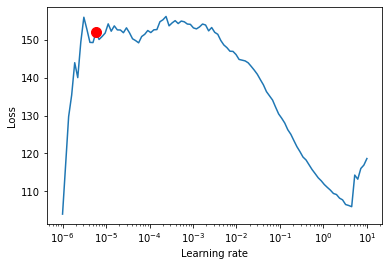

In [13]:
# find optimal learning rate
res = trainer.tuner.lr_find(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

In [14]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=3,
    gpus=0,
    enable_model_summary=True,
    gradient_clip_val=0.1,
    limit_train_batches=30,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=16,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Number of parameters in network: 22.7k


In [15]:
sample = next(iter(train_dataloader))[0]
print(sample['target_scale'].shape)
valid= next(iter(val_dataloader))[0]
print(valid['target_scale'].shape)

torch.Size([128, 2])
torch.Size([350, 2])


In [16]:
# fit network


trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)


   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 1.2 K 
3  | prescalers                         | ModuleDict                      | 144   
4  | static_variable_selection          | VariableSelectionNetwork        | 2.0 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 3.9 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.3 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 1.1 

Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 42


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [17]:
#hyperparameter 튜닝
# import pickle

# from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

# # create study
# study = optimize_hyperparameters(
#     train_dataloader,
#     val_dataloader,
#     model_path="optuna_test",
#     n_trials=200,
#     max_epochs=50,
#     gradient_clip_val_range=(0.01, 1.0),
#     hidden_size_range=(8, 128),
#     hidden_continuous_size_range=(8, 128),
#     attention_head_size_range=(1, 4),
#     learning_rate_range=(0.001, 0.1),
#     dropout_range=(0.1, 0.3),
#     trainer_kwargs=dict(limit_train_batches=30),
#     reduce_on_plateau_patience=4,
#     use_learning_rate_finder=False,  # use Optuna to find ideal learning rate or use in-built learning rate finder
# )

# # save study results - also we can resume tuning at a later point in time
# with open("test_study.pkl", "wb") as fout:
#     pickle.dump(study, fout)

# # show best hyperparameters
# print(study.best_trial.params)

In [18]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

In [19]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)

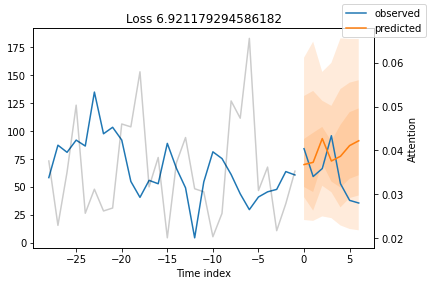

In [20]:
for idx in range(1):  # plot 10 examples
    best_tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);

In [21]:
raw_predictions['prediction'].shape

torch.Size([350, 7, 7])

In [22]:
# select last 24 months from data (max_encoder_length is 24)
encoder_data = df[lambda x: x.time_idx > x.time_idx.max() - max_encoder_length]

# select last known data point and create decoder data from it by repeating it and incrementing the month
# in a real world dataset, we should not just forward fill the covariates but specify them to account
# for changes in special days and prices (which you absolutely should do but we are too lazy here)
last_data = df[lambda x: x.time_idx == x.time_idx.max()]

decoder_data = pd.concat(
    [last_data.assign(date_var = lambda x: x[date_var] + pd.offsets.MonthBegin(i),
                      time_idx = lambda x: x.time_idx + i) 
                    for i in range(1, max_prediction_length + 1)], ignore_index=True, )
decoder_data.loc[:, date_var] = decoder_data['date_var']
decoder_data.drop('date_var', axis=1, inplace=True)

# adjust additional time feature(s)
decoder_data[unit] = decoder_data[date_var].dt.month.astype(str).astype("category")  # categories have be strings

# combine encoder and decoder data
new_prediction_data = pd.concat([encoder_data, decoder_data], ignore_index=True)

In [23]:
new_raw_predictions, new_x = best_tft.predict(new_prediction_data, mode="raw", return_x=True)

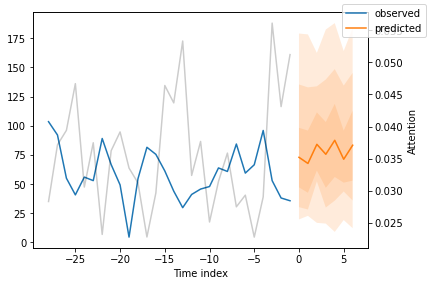

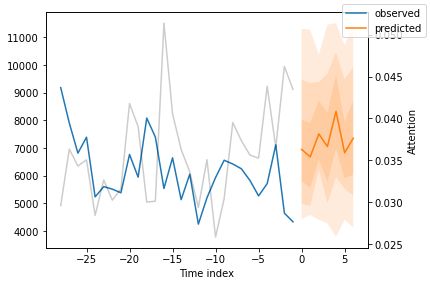

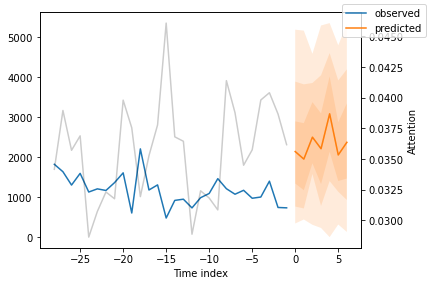

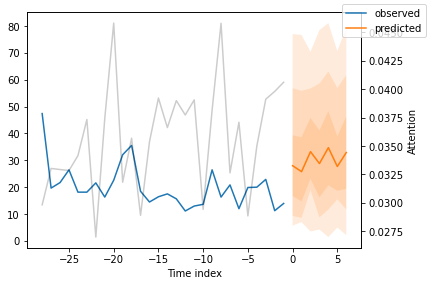

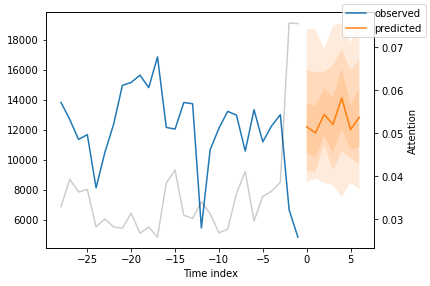

In [24]:
for idx in range(5):  # plot 10 examples
    best_tft.plot_prediction(new_x, new_raw_predictions, idx=idx, show_future_observed=False);

In [87]:
preds = new_raw_predictions['prediction'].squeeze()

In [89]:
preds[0].numpy()

array([[ 19.48835 ,  30.061451,  47.039017,  72.81941 ,  98.13797 ,
        135.38907 , 179.1264  ],
       [ 22.576134,  28.031704,  42.395374,  67.576866,  95.79261 ,
        132.90866 , 178.37341 ],
       [ 16.548172,  52.17909 ,  61.41655 ,  83.98038 , 111.38241 ,
        133.80405 , 162.47882 ],
       [ 15.9179  ,  29.70617 ,  46.681564,  75.443695, 103.127144,
        139.65085 , 182.55945 ],
       [  8.786781,  35.614536,  55.961494,  87.44336 , 118.68564 ,
        148.5625  , 188.08167 ],
       [ 18.961472,  43.504757,  51.09231 ,  71.17199 ,  95.75534 ,
        134.4553  , 164.1416  ],
       [ 11.987449,  35.722645,  52.810207,  83.20281 , 112.88992 ,
        145.3169  , 183.64377 ]], dtype=float32)

In [104]:
best_tft.dataset_parameters['target_normalizer'].groups

['sku', 'agency']